<a href="https://colab.research.google.com/github/dgrandis/NU/blob/main/%D0%A2%D0%B5%D0%BF%D0%BB%D0%BE%D0%B2_Pro_%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задание Pro**

Добейтесь средней точности **91-92%** в задаче поиска мошеннических операций. Для этого попробуйте сделать более мощный автокодировщик и гибкую настройку порога (bias), по которому мы определяем, мошенническая транзакция или нет

Постройте на одном графике **2** гистограммы (density=True) для нормальных и мошеннических транзакций. По графику определите **3** порога:

1) при котором все мошеннические транзакции будут пойманы

2) “оптимальный порог” - на пересечении распределений

3) при котором ни одна нормальная транзакция не будет распознана, как мошенническая

# Подключение библиотек

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Reshape, Conv2DTranspose, Activation, MaxPooling2D, Conv2D, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from google.colab import drive
sns.set_style('darkgrid')

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Создание функций

In [ ]:
# Функция создания автокодировщика

def baseAutoencoder(shape=(112,80,1)):
  img_input = Input((shape))   # Входные размеры

  x = Conv2D(32, (3,3), padding='same', activation='relu')(img_input)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  z = MaxPooling2D()(x)   

  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', activation='relu')(z)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(shape[-1], (3,3), padding='same', activation='sigmoid')(x)

  model = Model(img_input, x)

  model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

  return model

In [ ]:
# Функция вывода изображения как картинок

def plotImages(xTrain, pred, shape=(112,80)):
  n = 5  # Кол-во картинок
  plt.figure(figsize=(14,7))  # Задаем фигуру и ее размер

  for i in range(n):
    index = np.random.randint(0, pred.shape[0])
    print(index)
    # Картинки из тестового набора
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xTrain[index].reshape(shape))
    plt.gray()
    # Скрываем выводы координатных осей x и y. 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Восстановленные картинки
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(pred[index].reshape(shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()



In [ ]:
# Функция для расчета среднеквадратичной ошибки - mse
def getMSE(x1, x2):
  x1 = x1.flatten()
  x2 = x2.flatten()
  delta = x1 - x2
  return sum(delta**2) / len(delta)

## Определение мошеннических операций


In [4]:
df = pd.read_csv("/content/drive/MyDrive/УИИ/Автокодировщики/База CREDITCARD/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data = df.drop(['Time'], axis=1)  # Удаляем столбец Time

In [7]:
# Нормализуем столбец с суммой первода
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

In [8]:
# Записываем операции: frauds - мошеннические, normal - нормальные
normal = data[data.Class == 0]
frauds = data[data['Class'] == 1]


In [9]:
print("Мошеннические операции", frauds.shape)
print("Нормальные операции", normal.shape)

Мошеннические операции (492, 30)
Нормальные операции (284315, 30)


In [10]:
RANDOM_SEED = 10  # Задаем случайное значение

xTrain, xTest = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)


In [11]:
print("Размер обучающей выборки:", xTrain.shape)
print("Размер тестовой выборки: " , xTest.shape)

Размер обучающей выборки: (227452, 30)
Размер тестовой выборки:  (56863, 30)


In [12]:
# Удаляем Class в обучающем наборе
xTrain = xTrain.drop(['Class'], axis=1)

In [13]:
# Добавляем все мошеннические транзакции в тестовый набор данных
xTest = pd.concat([xTest, frauds])
print("Размер тестовой выборки вместе с мошенническими операциями: " , xTest.shape)    # 56863 + 492 = 57355

Размер тестовой выборки вместе с мошенническими операциями:  (57355, 30)


In [14]:
# Делаем метки(ответы) для тестового набора данных
yTest = xTest['Class']

In [15]:
# Удаляем класс у тестового набора данных
xTest = xTest.drop(['Class'], axis=1)

In [16]:
# Преобразуем данные в массивы numpy
xTrain = xTrain.values
xTest = xTest.values

In [20]:
print("Размер обучающей выборки:", xTrain.shape)
print("Размер тестовой выборки: " , xTest.shape)

Размер обучающей выборки: (227452, 29)
Размер тестовой выборки:  (57355, 29)


## Функция создания автокодировщика

In [24]:
def Autoencoder():

  dataSize = xTrain.shape[1]              # Берем размеры X_train по второй оси - (29)

  dataInput = Input(shape=(dataSize, ))   # и задаем эти размеры как входные в сеть (29, )

  x = Dense(10,activation='relu')(dataInput) 
  x = Dense(dataSize, activation='linear')(x)

  autoencoder = Model(inputs=dataInput, outputs=x)

  autoencoder.compile(optimizer='Adam', loss='mse')

  return autoencoder

In [25]:
model = Autoencoder()

## Модель сети

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 29)                319       
Total params: 619
Trainable params: 619
Non-trainable params: 0
_________________________________________________________________


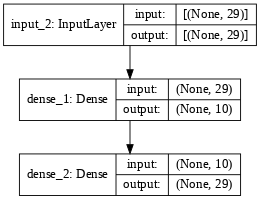

In [27]:
plot_model(model, dpi=65, show_shapes=True)

## Обучение сети

In [28]:
# Воспользуемся callback для лучшего обучения (изменения шага обучения)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001)

In [29]:
historyCreditCard = model.fit(xTrain, xTrain, epochs=100, batch_size=100, callbacks=[reduce_lr])

Epoch 1/100
2275/2275 [==============================] - 3s 954us/step - loss: 0.6016
Epoch 2/100
2275/2275 [==============================] - 2s 938us/step - loss: 0.3816
Epoch 3/100
2275/2275 [==============================] - 2s 938us/step - loss: 0.3687
Epoch 4/100
2275/2275 [==============================] - 2s 934us/step - loss: 0.3657
Epoch 5/100
2275/2275 [==============================] - 2s 952us/step - loss: 0.3601
Epoch 6/100
2275/2275 [==============================] - 2s 946us/step - loss: 0.3560
Epoch 7/100
2275/2275 [==============================] - 2s 928us/step - loss: 0.3552
Epoch 8/100
2275/2275 [==============================] - 2s 957us/step - loss: 0.3547
Epoch 9/100
2275/2275 [==============================] - 2s 947us/step - loss: 0.3547
Epoch 10/100
2275/2275 [==============================] - 2s 933us/step - loss: 0.3546
Epoch 11/100
2275/2275 [==============================] - 2s 958us/step - loss: 0.3546
Epoch 12/100
2275/2275 [============================

In [30]:
model.save_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelCreditPro.h5')
# model.load_weights('/content/drive/MyDrive/УИИ/Автокодировщики/Результат/modelCreditPro.h5')

## График обучения

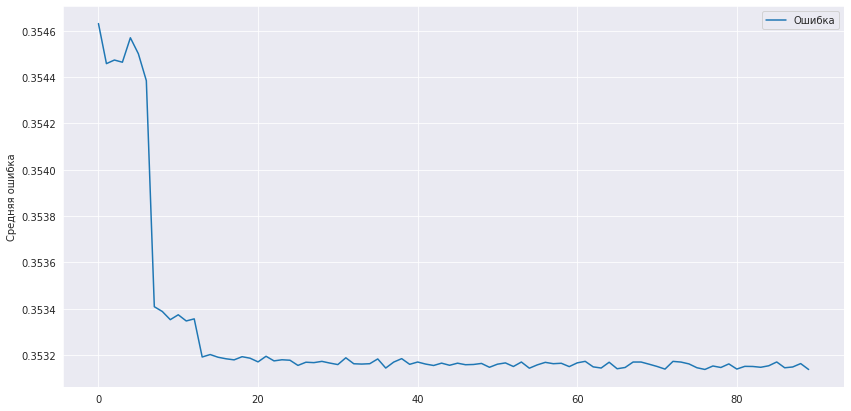

In [31]:
plt.figure(figsize=(14,7))
plt.plot(historyCreditCard.history['loss'][10:], label='Ошибка')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Результат

In [32]:
# Делаем предикт
pred = model.predict(xTest)

In [33]:
# Определяем среднеквадратичную ошибку
mse = np.mean(np.power(xTest-pred, 2), axis=1) 

In [34]:
mse_normal = mse[yTest.values == 0]   # Через маску найдем среднеквадратичную ошибку на нормальных операциях
mse_frauds = mse[yTest.values == 1]   # Через маску найдем среднеквадратичную ошибку на мошеннических операциях

In [35]:
print("Минимальная ошибка нормальных транзакций: ", round(min(mse_normal), 4)) 
print("Максимальная ошибка нормальных транзакций:", round(max(mse_normal), 4)) 
print("Средняя ошибка нормальных транзакций:     ", round(sum(mse_normal) / len(mse_normal), 4)) 

Минимальная ошибка нормальных транзакций:  0.0432
Максимальная ошибка нормальных транзакций: 87.0871
Средняя ошибка нормальных транзакций:      0.3502


In [36]:
print("Минимальная ошибка мошеннических транзакций: ", round(min(mse_frauds),4))
print("Максимальная ошибка мошеннических транзакций:", round(max(mse_frauds),4)) 
print("Средняя ошибка мошеннических транзакций:     ", round(sum(mse_frauds) / len(mse_frauds),4)) 

Минимальная ошибка мошеннических транзакций:  0.1578
Максимальная ошибка мошеннических транзакций: 94.1654
Средняя ошибка мошеннических транзакций:      18.7449


In [ ]:
#  Расставим значения на числовой прямой

#      MinN     MinF      MeanN     MeanF      MaxN     MaxF
#      0.04     0.158     0.3502    18.78      86.73    94.76
#   ----x---------x---------x---------x----------x--------x----->

In [37]:
def getACCByBias(bias):
  isNormal = mse_normal < bias   # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias   # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal)  # Процент нормальных операций
  accFrauds = sum(isFrauds) / len(isFrauds)  # Процент мошеннических операций

  print("Распознано нормальных транзакций: ", round(100 * accNormal), "%")
  print("Распознано мошеннических транзакций: ", round(100 * accFrauds), "%")
  print("Средняя точность распознавания: ", round((100 * (accNormal + accFrauds))/ 2), "%")

**Попробуем разное пороговое значение**

In [38]:
getACCByBias(0.65)

Распознано нормальных транзакций:  93 %
Распознано мошеннических транзакций:  89 %
Средняя точность распознавания:  91 %


In [39]:
getACCByBias(0.7)

Распознано нормальных транзакций:  94 %
Распознано мошеннических транзакций:  88 %
Средняя точность распознавания:  91 %


In [40]:
getACCByBias(0.6)

Распознано нормальных транзакций:  91 %
Распознано мошеннических транзакций:  91 %
Средняя точность распознавания:  91 %


In [41]:
getACCByBias(0.8)

Распознано нормальных транзакций:  96 %
Распознано мошеннических транзакций:  88 %
Средняя точность распознавания:  92 %


In [42]:
getACCByBias(0.85)

Распознано нормальных транзакций:  97 %
Распознано мошеннических транзакций:  87 %
Средняя точность распознавания:  92 %


In [43]:
getACCByBias(0.9)

Распознано нормальных транзакций:  97 %
Распознано мошеннических транзакций:  87 %
Средняя точность распознавания:  92 %
